# Introduction to TACO

TACO, which stands for **T**ensor **A**lgebra **Co**mpiler, is a library for performing sparse and dense linear algebra and tensor algebra computations. 

The computations can range from relatively simple ones like sparse matrix-vector multiplication to more complex ones like matricized tensor times Khatri-Rao product. All these computations can be performed on any mix of dense and sparse tensors. Under the hood, TACO automatically generates efficient code to perform these computations.

This notebook provides a brief introduction to the TACO Python Library. For a more comprehensive overview, please see the documentation linked [here](http://tensor-compiler.org/symphony-docs/index.html). We will also link to relevant pages as we progress.

## Getting Started

First, let's import TACO. Press Shift + Enter to run the code below. 

In [1]:
import pytaco as pt
from pytaco import dense, compressed

In the above, `dense` and `compressed` are [mode (dimension) formats](http://tensor-compiler.org/symphony-docs/reference/rst_files/mode_format.html). We can think of tensors as a multi-dimensional array, and the mode formats allow us to specify how we would like to store the data in each dimension: 
* If a dimension is `dense`, then all of the elements in that dimension are stored. 
* And if a dimension is `compressed`, then only non-zeros are stored.

For example, we can declare a $512 \times 64 \times 2048$ [tensor](http://tensor-compiler.org/symphony-docs/reference/rst_files/tensor_class.html) whose first dimension is dense and second and third dimensions are compressed:

In [2]:
A = pt.tensor([512, 64, 2048], pt.format([dense, compressed, compressed]))

We can initialize $A$ by calling its `insert` [method](http://tensor-compiler.org/symphony-docs/reference/rst_files/functions/pytaco.tensor.insert.html) to add a nonzero element to the tensor. The `insert` method takes two arguments: a list specifying the coordinates of the nonzero element to be added and the value to be inserted at that coordinate:

In [3]:
# Set A(0, 1, 0) = 42.0
A.insert([0, 1, 0], 42.0)

If multiple elements are inserted at the same coordinates, they are summed together:

In [4]:
# Set A(0, 0, 1) = 12.0 + 24.0 = 36.0
A.insert([0, 0, 1], 12.0)
A.insert([0, 0, 1], 24.0)

We can then iterate over the nonzero elements of the tensor as follows:

In [5]:
for coordinate, value in A: 
    print("At coordinate {}, the value is {}".format(coordinate, value))

At coordinate [0, 0, 1], the value is 36.0
At coordinate [0, 1, 0], the value is 42.0


## Defining Tensor Formats

Consider a matrix $M$ (aka a two-dimensional tensor) containing the following values:
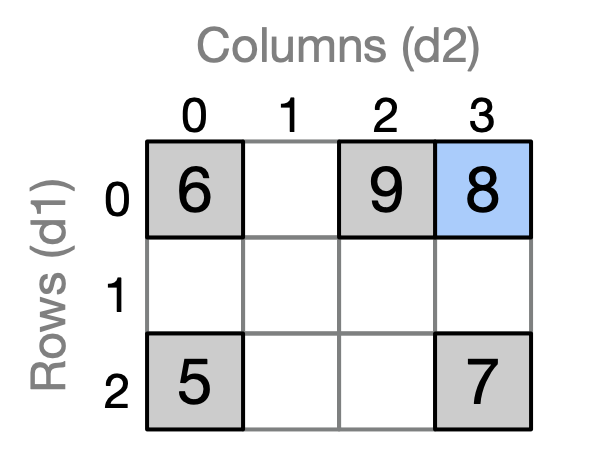

We will look at how $M$ is represented differently in different formats. For convenience, let's define a helper function to initialize $M$. 

In [6]:
def make_example_matrix(format):
    M = pt.tensor([3, 4], format)
    M.insert([0, 0], 6)
    M.insert([0, 2], 9)
    M.insert([0, 3], 8)
    M.insert([2, 0], 5)
    M.insert([2, 3], 7)
    return M

**Example 1**: Both $d_1$ and $d_2$ are dense.  

Note that passing in `dense` makes all of the dimensions dense. This is equivalent to passing in `pt.format(dense, dense)`.

In [7]:
make_example_matrix(dense)

A24 (3x4) ({dense},{dense}; 0,1):
dense (0): 
  [3]
dense (1): 
  [4]
[6, 0, 9, 8, 0, 0, 0, 0, 5, 0, 0, 7]

For this example, we focus on the last line of the output, the `vals` array: since all values are stored, it is simply a flattened $3 \times 4$ matrix.

**Example 2**: $d_1$ is dense and $d_2$ is compressed.

This is called compressed sparse row format. 

In [8]:
csr = pt.format([dense, compressed])

In [9]:
make_example_matrix(csr)

A42 (3x4) ({dense},{compressed}; 0,1):
dense (0): 
  [3]
compressed (1): 
  [0, 3, 3, 5]
  [0, 2, 3, 0, 3]
[6, 9, 8, 5, 7]

Listed under `compressed (1)` is a `pos` array on top and an `idx` array below; these together form a segmented vector with one segment per entry in the previous dimension. The `idx` array stores all the indices with nonzero values in the dimension, while the `pos` array stores the location in the `idx` array where each segment begins. Segment $i$ is stored in locations `pos[i]:pos[i+1]` in the `idx` array.

So, for our example: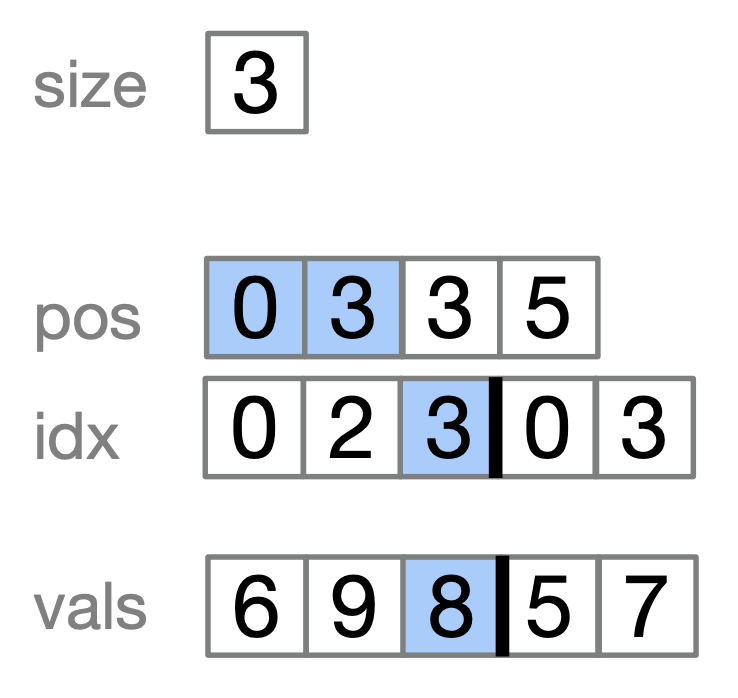

Let's find the value $8$. It's in row $0$, so it is in segment $0$. Then, `pos[0]:pos[1]` tells us that the column numbers in row $0$ that have nonzero values are stored in `idx[0]`, `idx[1]`, and `idx[2]`. We find that `idx[2] = 3`, which is the column number of $8$. So, we access `vals[2]`  — and find $8$!

## Example Application: SpMV

Sparse matrix-vector multiplication (SpMV) is a bottleneck computation in many scientific and engineering computations. Mathematically, SpMV can be expressed as $$y = Ax + z,$$ 

where where $A$ is a sparse matrix and $x$, $y$, and $z$ are dense vectors. The computation can also be expressed in [index notation](http://tensor-compiler.org/symphony-docs/pycomputations/index.html#specifying-tensor-algebra-computations) as 

$$y_i = A_{ij} \cdot x_j + z_i.$$

We will use the TACO Python library to easily and efficiently compute SpMV.

Rather than manually constructing a tensor, we load a tensor directly from a file by invoking the `pytaco.read` [function](http://tensor-compiler.org/symphony-docs/reference/rst_files/functions/pytaco.read.html) and specifying a format.

In [10]:
S = pt.read("pwtk.mtx", csr)

We can see the dimensions of $S$ using its `shape` attribute:

In [11]:
S.shape

[217918, 217918]

Examining the formula above, we need to define a vector $x$ whose length is the number of columns of $S$, and a vector $z$ whose length is the number of rows. We generate $x$ and $z$ with `numpy` randomly, and convert it to a TACO tensor using the `pytaco.from_array` [function](http://tensor-compiler.org/symphony-docs/reference/rst_files/functions/pytaco.from_array.html). 

In [12]:
import numpy as np
x = pt.from_array(np.random.uniform(size=S.shape[1]))
z = pt.from_array(np.random.uniform(size=S.shape[0]))

And we'll express the result $y$ as a dense vector. 

In [13]:
y = pt.tensor([S.shape[0]], dense)

The syntax for TACO computations closely mirrors index notation, with the caveat that we also have to explicitly declare the index variables beforehand:

In [14]:
i, j = pt.get_index_vars(2)
y[i] = S[i, j] * x[j] + z[i]

We could print $y$, but it's quite large, so to keep our computers happy, we'll just show 100 values: 

In [15]:
count = 0
for coordinate, value in S: 
    if count < 100: 
        print("At coordinate {}, the value is {}".format(coordinate, value))
        count += 1
    else:
        break

At coordinate [0, 0], the value is 37423.0879671
At coordinate [0, 1], the value is -22.4050781162
At coordinate [0, 2], the value is -300.654980157
At coordinate [0, 3], the value is -0.00317872095729
At coordinate [0, 4], the value is 130.602122322
At coordinate [0, 5], the value is -0.0417512516724
At coordinate [0, 6], the value is -15124.1528425
At coordinate [0, 7], the value is 27253.147717
At coordinate [0, 8], the value is 54.9607848282
At coordinate [0, 9], the value is 6.95630065861
At coordinate [0, 10], the value is 67.0246154049
At coordinate [0, 11], the value is -10303.1333116
At coordinate [0, 354], the value is -15124.2001756
At coordinate [0, 355], the value is -27224.5178558
At coordinate [0, 356], the value is 59.3991294686
At coordinate [0, 357], the value is -7.25766590362
At coordinate [0, 358], the value is 67.0129216298
At coordinate [0, 359], the value is 10303.1301715
At coordinate [0, 360], the value is -13723.7474449
At coordinate [0, 361], the value is -9

Finally, we’ll write the result to a file.

In [17]:
pt.write("y.tns", y)